# Wilkens LET model
Wilkens [1] described analytical model for LET calculation. The model is able to predict dose- and track-averaged values in the pencil proton beamlets. The calculations are limited to center-of-axis values and to liquid water.

The model is based on the Bortfeld analytical approximation of proton stopping power in water:

$$
\tilde S(r)  = \frac{r^{1/p - 1}}{p \alpha^{1/p}}
$$

where $r$ is the residual range ($R_0-z$).

Bragg-Kleeman rule which relates range of protons with its initial kinetic energy employs the same constants $p$ and $\alpha$:

$$
R_0(E) = \alpha E^p
$$

Another assumption is energy distribution of proton beamlet follows gaussian distribution at every point of the beam. Nuclear reactions are neglected in this model.

The model provides $LET$ as a function of: 
  - $z$ - depth in water (in cm)
  - $E$ - kinetic energy of proton entering water target (in MeV)
  - $\sigma_E$ - Gaussian energy spread (in MeV)


For the reference, see: 

[1] Wilkens JJ, Oelfke U. "Analytical linear energy transfer calculations for proton therapy" Med Phys. 2003 May;30(5):806-15. (DOI: 10.1118/1.1567852)

## Energy, range and stopping power

In [1]:
# first some necessary python imports
import numpy as np
import mpmath as mp # its part of sympy, offers high-precition floating-point arithmetic
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class ERSCalc(object):
    """A 'calculator' class for stopping power and range of protons"""
    alpha_cm_MeV = 0.0022
    p = 1.77
    
    @classmethod
    def range_cm(cls, energy_MeV):
        """
        Bragg-Kleeman rule for energy-range relationship
        Equation (8) in [1]
        """
        return cls.alpha_cm_MeV * energy_MeV** cls.p
    
    @classmethod
    def stop_pow_MeV_cm(cls, resid_range_cm):
        """Bortfeld approximation for stopping power of protons"""
        return (resid_range_cm**(1.0/cls.p - 1.0)) / (cls.p * cls.alpha_cm_MeV**(1.0/cls.p))

In [3]:
# take as example some interesting proton beam energy
E_MeV = 70.0
# let's calculate range
range_cm = ERSCalc.range_cm( E_MeV )
# then at some specific depth lets obtain residual range
z_cm = 2.0
res_range_cm = range_cm - z_cm
stop_power_MeV_cm = ERSCalc.stop_pow_MeV_cm( res_range_cm )

# finally the printouts
print("Range of protons with energy {:3.1f} MeV is {:3.3} cm".format(E_MeV, range_cm))
print("Stopping power at energy {:3.1f} MeV and depth {:3.2f} cm is {:3.3} MeV/cm".format(E_MeV, z_cm, stop_power_MeV_cm))

Range of protons with energy 70.0 MeV is 4.06 cm
Stopping power at energy 70.0 MeV and depth 2.00 cm is 13.1 MeV/cm


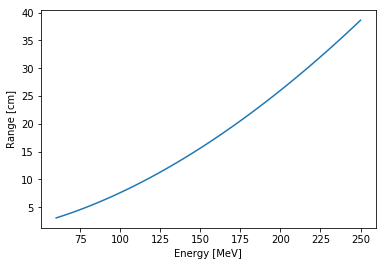

In [4]:
# some plots of range
E_MeV = np.linspace(start=60, stop=250, num=100)
range_cm = ERSCalc.range_cm( E_MeV )
plt.xlabel("Energy [MeV]")
plt.ylabel("Range [cm]")
plt.plot(E_MeV,range_cm)

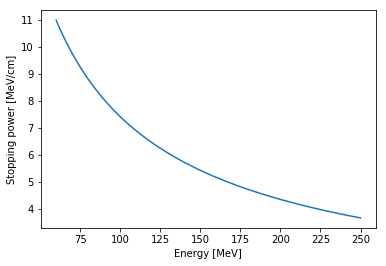

In [5]:
# some plots of stopping power
stop_power_MeV_cm = ERSCalc.stop_pow_MeV_cm( range_cm )
plt.xlabel("Energy [MeV]")
plt.ylabel("Stopping power [MeV/cm]")
plt.plot(E_MeV,stop_power_MeV_cm)

## Wilkens LET model

Wilkens LET model is based on following mathematical formalism. Dose averaged LET $L_d$ is described as:

$$
L_d(z) = \frac{\langle S^2\rangle_z}{\langle S\rangle_z}
$$

where $\langle S \rangle$ denotes stopping power averaged over an spectrum of protons with different residual range $r$. Following the formulas (A14) and (A12) from [1] we get:


$$
\langle S\rangle_z = \frac{\Phi_0}{\sqrt{2 \pi} \sigma R \alpha^{1/p}} \Bigg[ \sigma^{1 + 1/p} \Gamma\Big( 1 + \frac{1}{p}\Big) \tilde D_{1+1/p}(\xi, \zeta) - R \Big( \frac{R}{2}\Big)^{1/p} e^{-(\xi + \zeta)^2/8} \Bigg]
$$

$$
\langle S^2\rangle_z = \frac{\Phi_0}{\sqrt{2 \pi} \sigma R \alpha^{2/p} p (2-p)} \Bigg[ \sigma^{2/p} \Gamma\Big( \frac{2}{p}\Big) \tilde D_{2/p}(\xi, \zeta) - 2 R \Big( \frac{R}{2}\Big)^{2/p} e^{-(\xi + \zeta)^2/8} \Bigg]
$$

after simplifying we obtain:

$$
L_d(z, E, \sigma_E) = \frac{1}{\alpha^{1/p} p (2-p)} \frac{\sigma^{2/p} \Gamma\Big( \frac{2}{p}\Big) \tilde D_{2/p}(\xi, \zeta) - 2 R \Big( \frac{R}{2}\Big)^{2/p} e^{-(\xi + \zeta)^2/8}}{\sigma^{1 + 1/p} \Gamma\Big( 1 + \frac{1}{p}\Big) \tilde D_{1+1/p}(\xi, \zeta) - R \Big( \frac{R}{2}\Big)^{1/p} e^{-(\xi + \zeta)^2/8}}
$$

In this formula we have following variables:
 - $\alpha = 0.0022 \ \textrm{cm MeV}^{-p}$ 
 - $p = 1.77$
 - $R = 2 \mu m$ - regularization factor
 - $\sigma = \sqrt{\sigma_{\textrm{mono}}^2 + \sigma_r^2}$ - describes Gaussian spread of range (in cm)
 - $\sigma_{\textrm{mono}} = 0.012 R_0^{0.935}$ - accounts for range straggling of monoenergetic protons (in cm)
 - $\sigma_r = \sigma_E \alpha^{1/p} p R_0^{1 - 1/p}$ - accounts for initial energy spread translated into range spread (in cm)
 - $R_0 = \alpha E^p$ - range of protons with kinetic energy $E$ (in cm)
 - $\zeta = (z - R_0) / \sigma$ - helper variable
 - $\xi = (z - R_0 - R) / \sigma$ - helper variable
 - $\Gamma$ - gamma function
 - $\tilde D_\nu(x,y) = e^{-x^2/4} D_{-\nu}(x) - e^{-y^2/4} D_{-\nu}(y)$ - helper function
 - $D_\nu$ - parabolic cylinder function

In [6]:
class WilkensLET(object):
    R_cm = 2e-4 # 2 um regulatisation
    
    
    @staticmethod
    def parabolic_integral(nu, t):
        return np.array([float(mp.exp(-v**2/4.0)*mp.pcfd(-nu,v)) for v in t])
    
    @classmethod
    def d_tilde(cls, nu, xi, zeta):
        """helper function, equation (10) in [1]"""
        part1 = cls.parabolic_integral(nu, xi)
        part2 = cls.parabolic_integral(nu, zeta)
        return part1 - part2
        
    
    @classmethod
    def let_d_MeV_cm(cls, energy_MeV, sigma_energy_MeV, z_cm):
        """TODO
        """
        # range and residual range
        range_cm = ERSCalc.range_cm(energy_MeV)
        res_range_cm = range_cm - z_cm
        
        # range straggling of monoenergetical protons, see Appendix [1]
        sigma_mono_cm = 0.01 * range_cm**0.935
        
        # range equivalent of energy straggline, equation (A2) in [1]
        sigma_r_cm = sigma_energy_MeV * (ERSCalc.alpha_cm_MeV**(1.0/ERSCalc.p)) * ERSCalc.p * (range_cm**(1.0-1.0/ERSCalc.p))
                
        # total sigma, equation (A3) in [1]
        sigma_cm = (sigma_mono_cm**2 + sigma_r_cm**2)**0.5

        # zeta variable introduced for equation (A8) in [1]
        zeta = (z_cm - range_cm) / sigma_cm
        
        # xi variable introduced for equation (A11) in [1]
        xi = (z_cm - range_cm - cls.R_cm) / sigma_cm

        # main part of <S>_z as in quation (10) or (A12) in [1]
        q = 1.0+1.0/ERSCalc.p        
        mean_S_z_part = (sigma_cm**q) * mp.gamma(q) * cls.d_tilde(q, xi, zeta)
        mean_S_z_part -= cls.R_cm * ((0.5 * cls.R_cm)**(1.0/ERSCalc.p)) * np.exp(-(zeta**2 + xi**2)/8.0)
        
        # main part of <S2>_z as in quation (10) or (A14) in [1]
        r = 2.0/ERSCalc.p
        mean_S2_z_part = (sigma_cm**r) * mp.gamma(r) * cls.d_tilde(r, xi, zeta)
        mean_S2_z_part -= 2.0 * ((0.5 * cls.R_cm)**r) * np.exp(-(zeta**2 + xi**2)/8.0)
        
        # factor part of <S2>_z divided by <S>_z
        const_factor_MeV_cm = 1.0 / (ERSCalc.p * (2.0 - ERSCalc.p) * ERSCalc.alpha_cm_MeV ** (1.0/ERSCalc.p))
        
        # result
        result = const_factor_MeV_cm * mean_S2_z_part / mean_S_z_part
        
        # filling nonsense values (outside model domain) with np.nan
        result[res_range_cm < 0] = np.nan
        
        return result

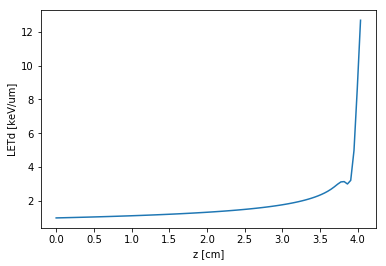

In [7]:
E_MeV = 70
sigma_E_MeV = 0.5
z_cm = np.linspace(start=0, stop=4.3, num=100)
let_MeV_cm = WilkensLET.let_d_MeV_cm(E_MeV, sigma_E_MeV, z_cm)
let_keV_um = 0.1 * let_MeV_cm

plt.xlabel("z [cm]")
plt.ylabel("LETd [keV/um]")
plt.plot(z_cm, let_keV_um)